# Introduction to Dynamical Systems and Chaos

## Section 3

### A Naïve Population Equation

Population doubling every year:

$f(P) = 2 P$

$P_{n+1} = 2 P_n$

We'll use Maxima's Lisp support to explore our models, starting with some utility functions we'll need:

In [2]:
to_lisp()$


Type (to-maxima) to restart, ($quit) to quit Maxima.


In [3]:
(defun tuples->maxima (data)
  "Convert pairs to Maxima format."
  (cons '(mlist) 
        (map 'list (lambda (x) `((mlist) ,@x)) data)))

(defun maxima->tuples (data)
  "Convert pairs from maxima format."
  (mapcar #'cdr (cdr data)))

(defun $max_x (data)
  "Get the largest numerical element in the list."
  (apply #'max (mapcar #'car (maxima->tuples data))))

(defun $max_y (data)
  "Get the smallest numerical element in the list."
  (apply #'max (mapcar #'cadr (maxima->tuples data))))

(defun interleave (data1 data2)
  "Given two lists, combine them returning a list wHere the elements are alternated such
  that the first two elements are the first element of `data1` and `data2`, respectively;
  the next two elements are the second element of `data1` and `data2`, etc."
  (if (and (not (null data1)) (not (null data2)))
    (cons (car data1) (cons (car data2)
                            (interleave (cdr data1) (cdr data2))))))

(defun group-n (data count)
  "Given a list of elements, group them into sublists, each of length `count`. For example,
  a list of 10 elements passed with `count` equal to `2` will be returned as a list of 
  five elements, where each of those is two elements long. Similarly, that same list 
  passed with a count of `5` would return a list of two elements where each element was a
  sublist five elements (representing the first five elements of the original list in the
  first sublist and the last five elements of the original list in the second sublist)."
  (if (not (null data))
    (cons (subseq data 0 count)
          (group-n (subseq data count) count))))

(defun get-differences (data1 data2)
  "Given two lists, pair each element of the two lists together, then subtract the 
  second element of each pair from the first element of each pair, returning a list
  of floating point numbers that represent the difference between corresponding 
  values."
  (mapcar (lambda (x) (abs (apply #'- x)))
          (group-n (interleave data1 data2) 2)))

(defun $get_differences (data1 data2)
  "Like 'get-differences', but this function is indented to be run from Maxima, taking 
  Maxiam-style lists as arguments and returning Maxima data."
  (cons '(mlist) (get-differences (maxima->tuples data1) (maxima->tuples data2))))

(defun list->maxima (data)
  "Convert pairs to Maxima format."
  (cons '(mlist) 
        data))
  
(defun discard-ts (data)
  "Discard the time portion of times series data, namely, the first elements of the
  point tuples."
  (mapcar #'cadr data))

(defun round-to (number precision &optional (what #'round))
  (let ((div (expt 10 precision)))
    (float (/ (funcall what (* number div)) div))))
         
(defun $subtract_points (data1 data2)
  (list->maxima 
    (mapcar (lambda (x) 
              (round-to x 5))
            (get-differences (discard-ts (maxima->tuples data1))
                             (discard-ts (maxima->tuples data2))))))

TUPLES->MAXIMA

MAXIMA->TUPLES

$MAX_X

$MAX_Y

INTERLEAVE

GROUP-N

GET-DIFFERENCES

$GET_DIFFERENCES

LIST->MAXIMA

DISCARD-TS

ROUND-TO

$SUBTRACT_POINTS

In [4]:
(defun $pop_double (x0 n)
  (labels ((pop0 (acc)
    (let ((step (length acc)))
      (if (eql step n) 
        (tuples->maxima acc)
        (let ((x-last (cadar (last acc))))
          (pop0 (append acc `((,step ,(* 2 x-last))))))))))
   (pop0 `((0 ,x0)))))

$POP_DOUBLE

In [5]:
(to-maxima)

Returning to Maxima


In [6]:
pop_0: 1$
steps: 11$
data: pop_double(pop_0, steps);

(%o12) [[0, 1], [1, 2], [2, 4], [3, 8], [4, 16], [5, 32], [6, 64], [7, 128], 
                                                [8, 256], [9, 512], [10, 1024]]

Now, let's plot it:

In [7]:
set_plot_option([svg_file, "maxplot.svg"])$

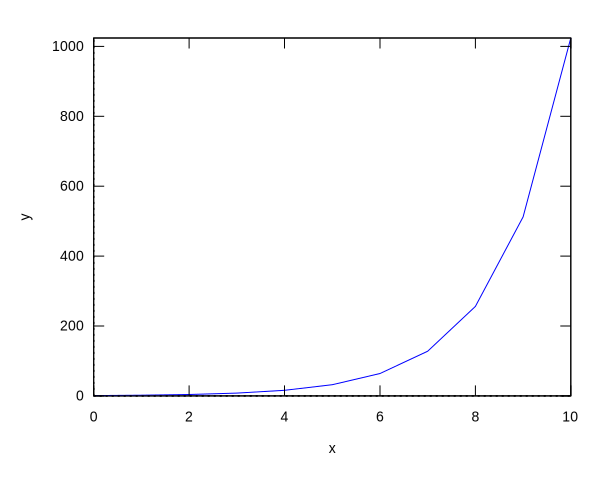

In [8]:
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

### The Logistic Equation

Above we double population; what if we generalize? For $r$ = birth rate,

$f(P) = r P$

$P_1 = r P_0$

$P_2 = r P_1$

...

$P_{t + 1} = r P_t$

This gives us three conditions:

1. $r > 1$: population grows to infinity 
1. $r = 1$: population remains the same
1. $0 < r < 1$: population approaches zero

This does not take into account the possibility of partial population declines even with overall growth. Let's make another modification:

$f(P) = r P \cdot (1 - \frac {P} {K})$

where $K$ is the "carry capacity" (in the lectures for this course, the professor calls it $A$, the "annihilation population") where, if this population is reached, the next iteration will result in no population:

$f(K) = r P \cdot (1 - \frac {P} {K}) = r K \cdot (0) = 0$

If the population is small ($P$ much less than $K$), then $f(P) \simeq r P$

Let's create an implementation of this model:

In [9]:
to_lisp()$


Type (to-maxima) to restart, ($quit) to quit Maxima.


In [10]:
(defun $population (p0 rate k n)
  (labels ((pop0 (acc)
    (let ((step (length acc)))
      (if (eql step n)
        (tuples->maxima acc)
        (let ((p-last (cadar (last acc))))
          (pop0 (append acc `((,step ,(* rate p-last (- 1 (/ p-last k))))))))))))
   (pop0 `((0 ,p0)))))

$POPULATION

In [11]:
(to-maxima)

Returning to Maxima


In [12]:
p0: 1.0$
birthrate: 2$
deathrate: 0$
rate: birthrate-deathrate$
k: 8$
steps: 8$
data: population(p0, rate, k, steps);

(%o22) [[0, 1.0], [1, 1.75], [2, 2.734375], [3, 3.59954833984375], 
[4, 3.959909616969526], [5, 3.999598190297117], [6, 3.999999959637241], 
[7, 4.0]]

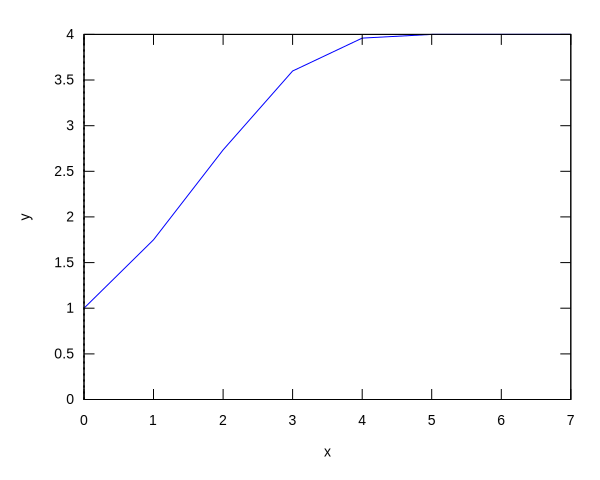

In [13]:
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

Now let's compare one year to the previous year's population:

In [14]:
to_lisp()$


Type (to-maxima) to restart, ($quit) to quit Maxima.


In [15]:
(defun $population_year_over_year (data)
  (labels ((pyoy0 (acc last-year remaining)
    (if (null remaining) 
      (tuples->maxima acc)
      (let ((this-year (cadar remaining)))
        (pyoy0 (append acc `((,last-year ,this-year))) this-year (cdr remaining))))))
    (pyoy0 '() 0 (maxima->tuples data))))

$POPULATION_YEAR_OVER_YEAR

In [16]:
(to-maxima)

Returning to Maxima


In [17]:
data: population_year_over_year(data);

(%o25) [[0, 1.0], [1.0, 1.75], [1.75, 2.734375], [2.734375, 3.59954833984375], 
[3.59954833984375, 3.959909616969526], [3.959909616969526, 3.999598190297117], 
[3.999598190297117, 3.999999959637241], [3.999999959637241, 4.0]]

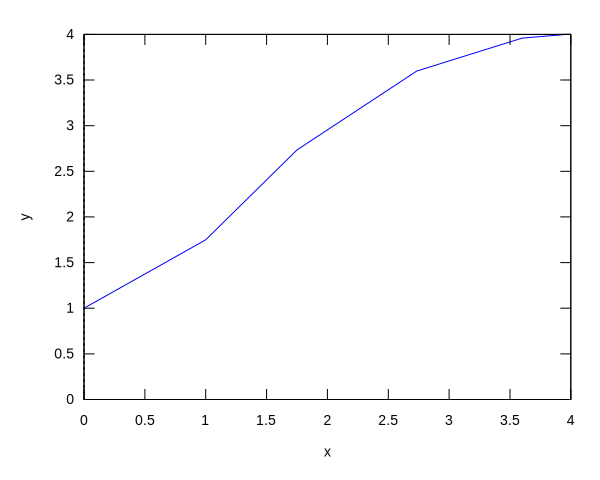

In [18]:
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

### Logistic Map

We can divide both sides of the logistic equation by the carrying capaticy:

$
\begin{align}
f(P) & = r P \cdot (1 - \frac {P}{K}) \\
\frac {f(P)}{K} & = \frac {r P}{K} \cdot (1 - \frac {P}{K}) \\
\end{align}
$

And then define $\frac {P}{K}$ as the population expressed as a fraction of the carrying capacity. Now we can rewrite the logistic equation using this definition:

$x_{n + 1} = r x_n \cdot (1 - x_n)$

or

$f(x) = r x \cdot (1 - x)$

or, in polynomial form

$f(x) = rx - rx^2$

In [19]:
to_lisp();


Type (to-maxima) to restart, ($quit) to quit Maxima.


In [20]:
(defun logistic-map (R x-last)
  (* R (- x-last (expt x-last 2))))

(defun $logistic_map (R x0 n)
  (labels ((lm0 (acc)
    (let ((step (length acc)))
      (if (eql step n) 
        (tuples->maxima acc)
        (let ((x-last (cadar (last acc))))
          (lm0 (append acc `((,step ,(logistic-map R x-last))))))))))
   (lm0 `((0 ,x0)))))

LOGISTIC-MAP

$LOGISTIC_MAP

In [21]:
(to-maxima)

Returning to Maxima


Let's run some numerical experiments:

In [22]:
R: 1.5$
x0: 0.2$
steps: 10$
data: logistic_map(R, x0, steps);

(%o31) [[0, 0.2], [1, 0.24], [2, 0.2736], [3, 0.29811456], 
[4, 0.3138634036740096], [5, 0.323029751262263], [6, 0.3280222965925552], 
[7, 0.3306355042960515], [8, 0.3319735013924208], [9, 0.3326506436485157]]

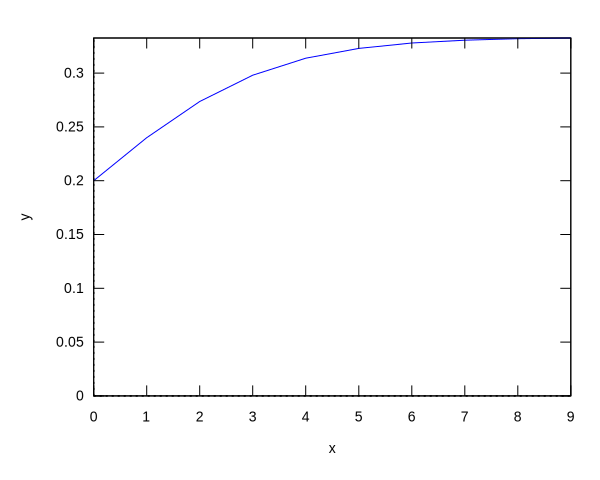

In [23]:
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

In [24]:
R: 3.1$
x0: 0.1$
steps: 10$
data: logistic_map(R, x0, steps);

(%o36) [[0, 0.1], [1, 0.279], [2, 0.6235928999999999], 
[3, 0.7276468647157291], [4, 0.6143484054538055], [5, 0.7344657707275336], 
[6, 0.6045799873071452], [7, 0.7410953813899958], [8, 0.5948063529244786], 
[9, 0.7471364418799936]]

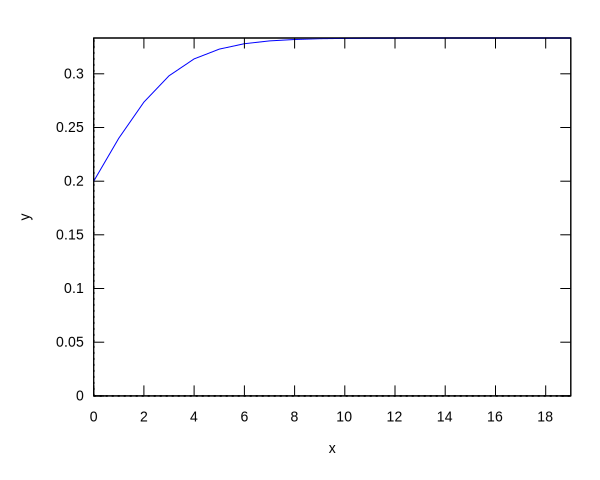

(%o40) [[0, 0.2], [1, 0.24], [2, 0.2736], [3, 0.29811456], 
[4, 0.3138634036740096], [5, 0.323029751262263], [6, 0.3280222965925552], 
[7, 0.3306355042960515], [8, 0.3319735013924208], [9, 0.3326506436485157], 
[10, 0.3329912893931159], [11, 0.3331621358721391], [12, 0.3332476906398801], 
[13, 0.3332905009846003], [14, 0.3333119144070517], [15, 0.3333226231820369], 
[16, 0.3333279780856241], [17, 0.3333306556664607], [18, 0.3333319944891421], 
[19, 0.333332663908549]]

In [25]:
R: 1.5$
x0: 0.2$
steps: 20$
data: logistic_map(R, x0, steps);
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

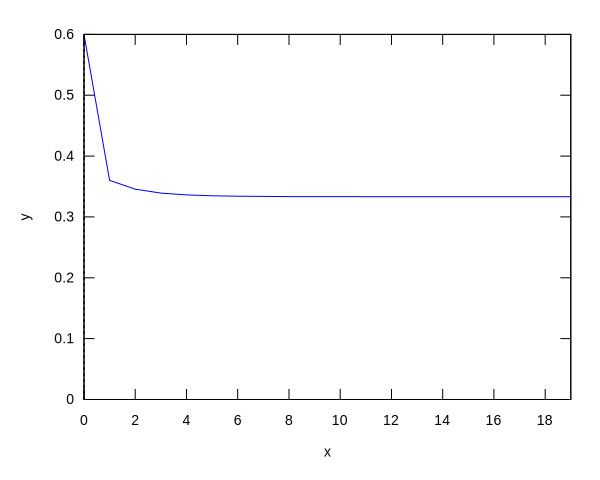

(%o45) [[0, 0.6], [1, 0.36], [2, 0.3456], [3, 0.33924096], 
[4, 0.3362347965874176], [5, 0.3347714372268533], [6, 0.3340492830658804], 
[7, 0.3336905393235776], [8, 0.3335117449342763], [9, 0.3334224913877558], 
[10, 0.3333779004368066], [11, 0.3333556139057299], [12, 0.3333444728748958], 
[13, 0.3333389029179805], [14, 0.3333361180791265], [15, 0.3333347256945977], 
[16, 0.3333340295110575], [17, 0.3333336814214684], [18, 0.3333335073772191], 
[19, 0.3333334203552308]]

In [26]:
R: 1.5$
x0: 0.6$
steps: 20$
data: logistic_map(R, x0, steps);
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

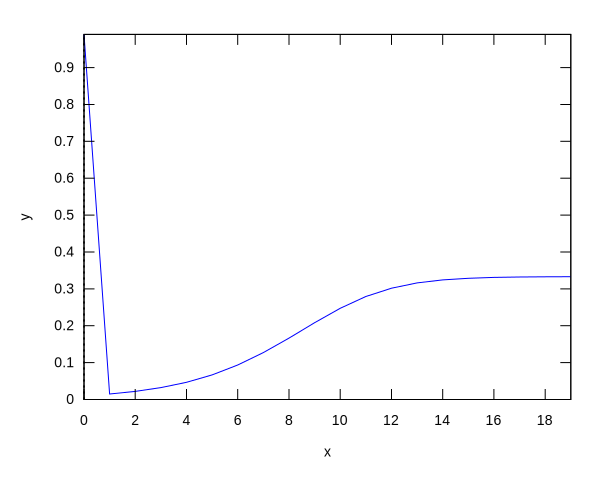

(%o50) [[0, 0.99], [1, 0.01485000000000003], [2, 0.02194421625000004], 
[3, 0.03219400143475992], [4, 0.04673632155956789], [5, 0.06682805670997283], 
[6, 0.09354310131951221], [7, 0.1271891842725595], [8, 0.1665181435149606], 
[9, 0.2081847770929374], [10, 0.2472658135195521], [11, 0.2791881464760992], 
[12, 0.3018631880150091], [13, 0.3161127056046366], [14, 0.3242781944399294], 
[15, 0.3286827705760631], [16, 0.3309756103537593], [17, 0.3321461335570737], 
[18, 0.3327376192802404], [19, 0.3330349439939373]]

In [27]:
R: 1.5$
x0: 0.99$
steps: 20$
data: logistic_map(R, x0, steps);
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

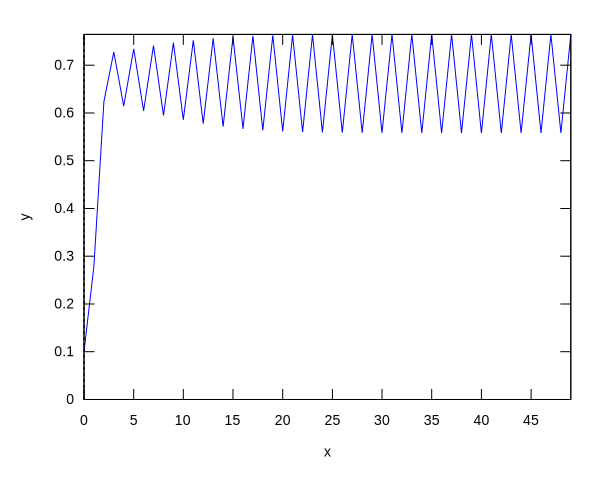

In [28]:
R: 3.1$
x0: 0.1$
steps: 50$
data: logistic_map(R, x0, steps)$
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

In [29]:
data[47];
data[48];
data[49];
data[50];

(%o57)                     [46, 0.5580179271142985]

(%o58)                     [47, 0.7645651524134158]

(%o59)                     [48, 0.5580163683982448]

(%o60)                     [49, 0.7645657130934254]

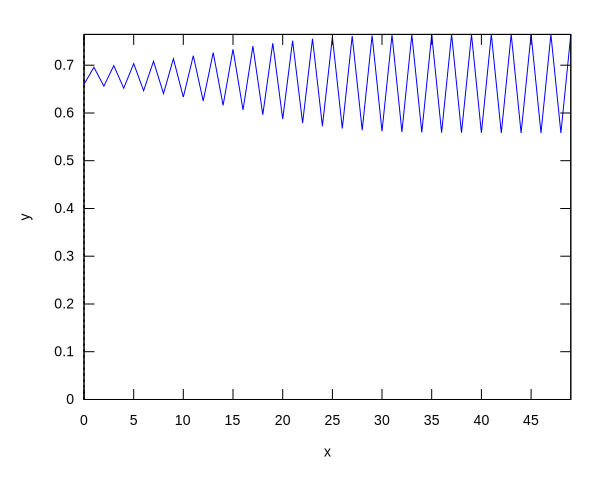

In [30]:
R: 3.1$
x0: 0.66$
steps: 50$
data: logistic_map(R, x0, steps)$
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

In [31]:
data[47];
data[48];
data[49];
data[50];

(%o66)                     [46, 0.5580723917004924]

(%o67)                     [47, 0.7645455516987723]

(%o68)                     [48, 0.5580485183368158]

(%o69)                     [49, 0.7645541455085912]

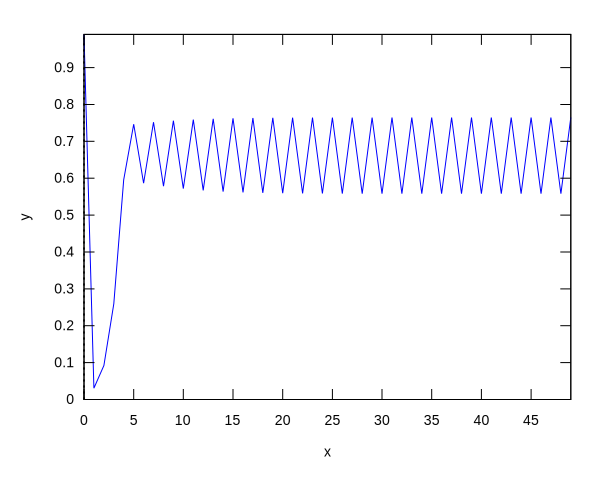

In [32]:
R: 3.1$
x0: 0.99$
steps: 50$
data: logistic_map(R, x0, steps)$
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

In [33]:
data[47];
data[48];
data[49];
data[50];

(%o75)                     [46, 0.5580155168117045]

(%o76)                     [47, 0.7645660194081195]

(%o77)                      [48, 0.558014946261082]

(%o78)                     [49, 0.7645662246320037]

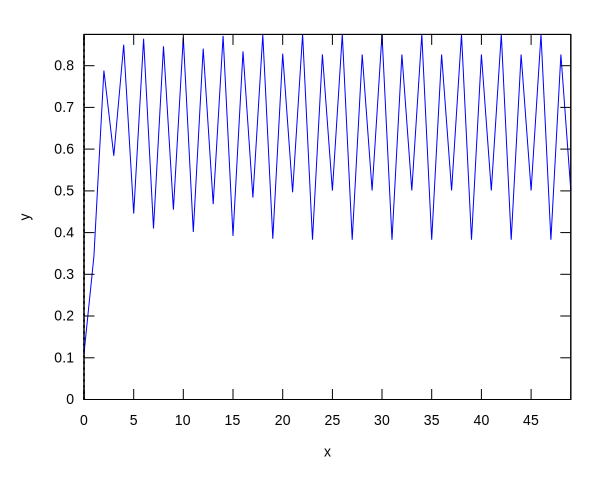

In [34]:
R: 3.5$
x0: 0.11$
steps: 50$
data: logistic_map(R, x0, steps)$
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

In [35]:
data[46];
data[47];
data[48];
data[49];
data[50];

(%o84)                     [45, 0.5008842103118396]

(%o85)                     [46, 0.8749972636024356]

(%o86)                     [47, 0.3828196830173989]

(%o87)                     [48, 0.8269407065914999]

(%o88)                     [49, 0.5008842103070776]

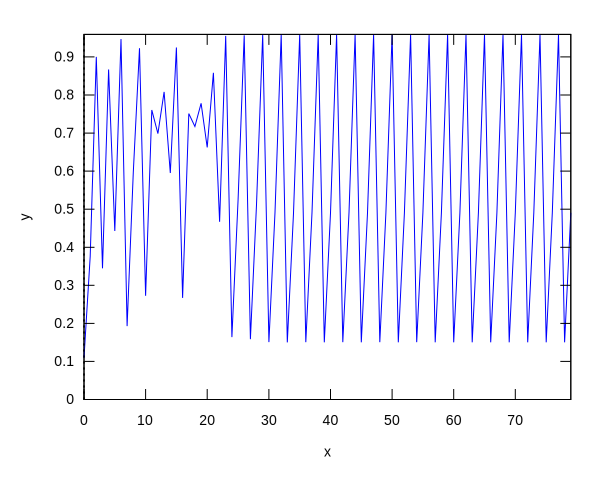

In [36]:
R: 3.838$
x0: 0.11$
steps: 80$
data: logistic_map(R, x0, steps)$
plot2d([[discrete,data]], [x, 0, max_x(data)], [y, 0, max_y(data)])$

In [37]:
data[77];
data[78];
data[79];
data[80];

(%o94)                     [76, 0.4903908008921666]

(%o95)                     [77, 0.9591456117166381]

(%o96)                     [78, 0.1503932091923173]

(%o97)                     [79, 0.4904008024095858]

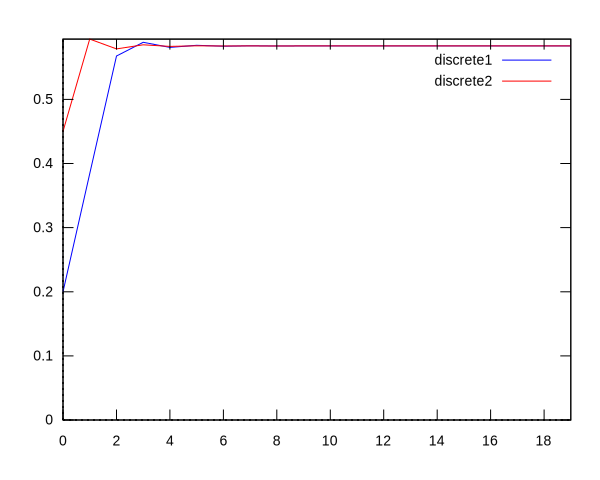

In [38]:
R: 2.4$
x01: 0.2$
steps: 20$
data1: logistic_map(R, x01, steps)$
x02: 0.45$
data2: logistic_map(R, x02, steps)$
plot2d([[discrete,data1],[discrete,data2]], [x, 0, max_x(join(data1,data2))], [y, 0, max_y(join(data1,data2))])$

In [39]:
subtract_points(data1, data2);

(%o105) [0.25, 0.21, 0.01109, 0.0039, 0.00163, 6.4e-4, 2.6e-4, 1.0e-4, 4.0e-5, 
                   2.0e-5, 1.0e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

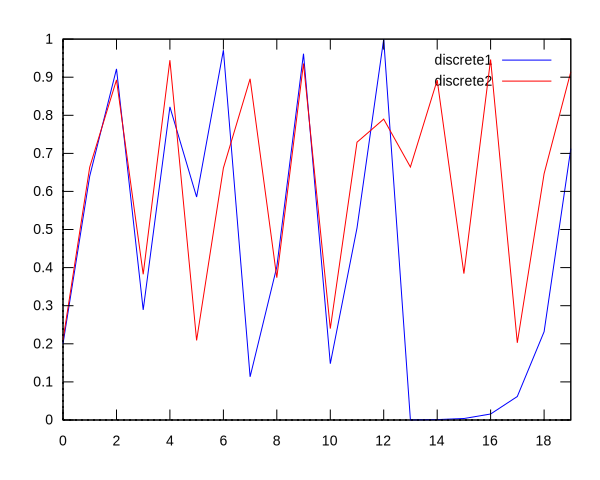

In [40]:
R: 4.0$
x01: 0.2$
steps: 20$
data1: logistic_map(R, x01, steps)$
x02: 0.21$
data2: logistic_map(R, x02, steps)$
plot2d([[discrete,data1],[discrete,data2]], [x, 0, max_x(join(data1,data2))], [y, 0, max_y(join(data1,data2))])$

In [41]:
subtract_points(data1, data2);

(%o113) [0.01, 0.0236, 0.02866, 0.09338, 0.12273, 0.37636, 0.30939, 0.78244, 
0.02852, 0.02562, 0.09199, 0.22531, 0.21014, 0.66381, 0.89135, 0.38035, 
0.93076, 0.14102, 0.41487, 0.20191]

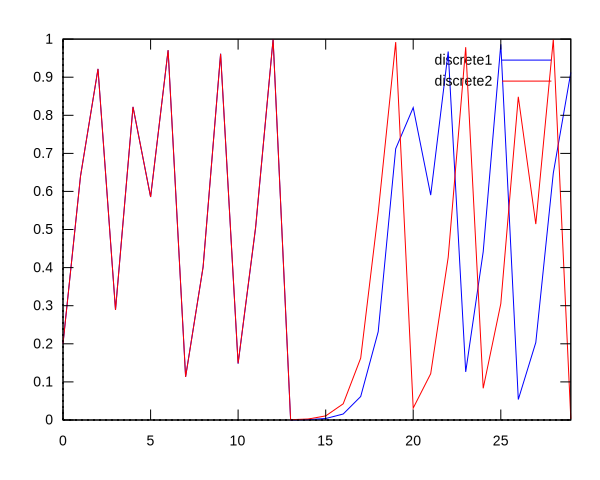

In [42]:
R: 4.0$
x01: 0.2$
steps: 30$
data1: logistic_map(R, x01, steps)$
x02: 0.200001$
data2: logistic_map(R, x02, steps)$
plot2d([[discrete,data1],[discrete,data2]], [x, 0, max_x(join(data1,data2))], [y, 0, max_y(join(data1,data2))])$

In [43]:
subtract_points(data1, data2);

(%o121) [0.0, 0.0, 0.0, 1.0e-5, 2.0e-5, 4.0e-5, 3.0e-5, 1.0e-4, 3.1e-4, 
2.5e-4, 9.1e-4, 0.00256, 1.1e-4, 4.3e-4, 0.0017, 0.00679, 0.02675, 0.10078, 
0.31273, 0.27997, 0.78864, 0.46882, 0.54026, 0.85234, 0.35837, 0.68102, 
0.79472, 0.31087, 0.35103, 0.90894]

### The Lorenz Equations

In [44]:
LZ1:'diff(x, t) = 10 * (x - y);
LZ2:'diff(y, t) = x * (28 - z) - y;
LZ3:'diff(z, t) = x*y - 8 / 3 * z;

                                dx
(%o122)                         -- = 10 (x - y)
                                dt

                              dy
(%o123)                       -- = x (28 - z) - y
                              dt

                                dz         8 z
(%o124)                         -- = x y - ---
                                dt          3

In [45]:
LZ1_ODE: ode2(LZ1, x, t);
LZ2_ODE: ode2(LZ2, y, t);
LZ3_ODE: ode2(LZ3, z, t);

                               10 t    - 10 t
(%o125)                  x = %e     (%e       y + %c)

                             - t    t
(%o126)                y = %e    (%e  (28 x - x z) + %c)

                                         8 t
                                8 t      ---
                              - ---       3
                                 3   3 %e    x y
(%o127)                 z = %e      (----------- + %c)
                                          8

In [46]:
LZ2_SOL: ic1(LZ2_ODE, x= 0, y= 5);
LZ2_SOL: ic1(LZ2_ODE, x= 0, y= 5);
LZ3_SOL: ic1(LZ3_ODE, x= 0, y= 5);

(%o128)                     y = (- x z) + 28 x + 5

(%o129)                     y = (- x z) + 28 x + 5

                                    8 z + 3 x y
(%o130)                         z = -----------
                                         8

In [47]:
load("dynamics");
load("draw");
numer: true;

(%o131)      /usr/share/maxima/5.43.0/share/dynamics/dynamics.mac

(%o132)          /usr/share/maxima/5.43.0/share/draw/draw.lisp

(%o133)                              true

In [ ]:
s: 10.0;
p: 28.0;
b: 8/3;
eq: [s*(y-x), x*(p-z)-y, x*y-b*z];
init: [1.0,0,0];
t: [t,0,100,.01];
sol: rk(eq, [x,y,z], init, t);

(%o134)                              10.0

(%o135)                              28.0

(%o136)                        2.666666666666667

(%o137)   [10.0 (y - x), x (28.0 - z) - y, x y - 2.666666666666667 z]

(%o138)                           [1.0, 0, 0]

(%o139)                        [t, 0, 100, 0.01]


Maxima encountered a Lisp error:

 Unhandled memory fault at #x7EFD1A9B8BC0.

Automatically continuing.
To enable the Lisp debugger set *debugger-hook* to nil.


In [ ]:

LZ1_SOL: rk(LZ1_ODE, t= 0, y= 5);[5.0,0,0],[t,0,1,0.1]
(%i9) init: ;

In [ ]:

numer:true;
s: 10.0;
p: 28.0;
b: 8/3;
init: [1.0,0,0];
t_range: [t,0,100,.01];
eq: [s*(y-x), x*(r-z) -y, xy - bz];
sol: rk(eq, [x,y,z],init,t_range)$

sol_pts: map( lambda([x], rest(x)), sol)$
draw3d(point_size=0,points_joined=true, points(sol_pts));

In [ ]:
draw3d(color=black, parametric(t,2*t^2,2,t,-4,4), enhanced3d = false, surface_hide=true, color=red, implicit(s,x,-3,3,y,0,15,z,1.6,2.4) )$
plot3d([cos(t), sin(t), t], [t,0,6*%pi], [u,-5,5], [gnuplot_pm3d,false])$


$f(x) = rx - rx^2$

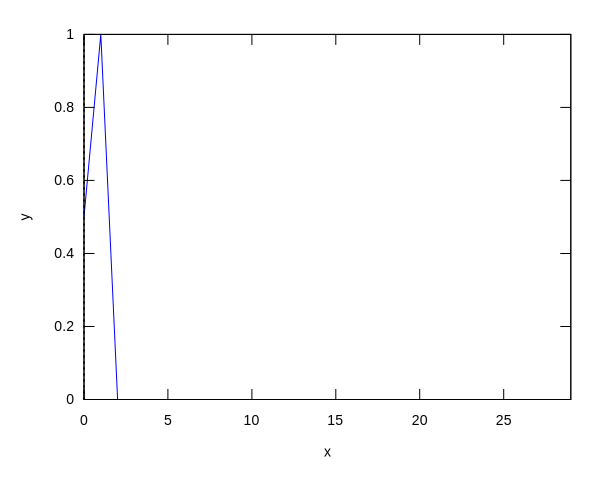

In [47]:
R: 4.0$
x01: 0.5$
steps: 30$
data1: logistic_map(R, x01, steps)$
x02: 0.500001$
x02: 0.4999999$
data2: logistic_map(R, x02, steps)$
plot2d([[discrete,data1]], [x, 0, max_x(join(data1,data2))], [y, 0, max_y(join(data1,data2))])$

In [49]:
4*0.5 - 4*0.25;

(%o158)                               1.0

In [51]:
4*1 - 4* 1;

(%o159)                                0